## Target guided ordinal encoding

In the previous lectures in this section on how to engineer the labels of categorical variables, we learnt how to convert a label into a number, by using one hot encoding or replacing by frequency or counts. These methods are simple, make no assumptions and work generally well in different scenarios.

There are however methods that allow us to capture information while pre-processing the labels of categorical variables. These methods include:

- Ordering the labels according to the target
- Replacing labels by the risk (of the target)
- Replacing the labels by the joint probability of the target being 1 or 0
- Weight of evidence.

### Monotonicity

All these methods create a monotonic relationship between the categorical variable and the target. A monotonic relationship is a relationship that does one of the following: (1) as the value of one variable increases, so does the value of the other variable; or (2) as the value of one variable increases, the other variable value decreases. In this case, as the value of the independent variable (predictor) increases, so does the target, or conversely, as the value of the variable increases, the target decreases.

In general:

### Advantages

- Capture information within the label, therefore rendering more predictive features
- Create a monotonic relationship between the variable and the target
- Do not expand the feature space

### Disadvantage

- Prone to cause over-fitting


### Note

The methods discussed in this and the coming 3 lectures can be also used on numerical variables, after discretisation. This creates a monotonic relationship between the numerical variable and the target, and therefore improves the performance of linear models. I will discuss this in more detail in the section "Discretisation".

### Ordering  labels according to the target

Ordering the labels according to the target means assigning a number to the label, but this numbering, this ordering, is informed by the mean of the target within the label.

Briefly, we calculate the mean of the target for each label/category, then we order the labels according to these mean from smallest to biggest, and we number them accordingly.

See the example below:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%cd ../data_set/
# let's load again the titanic dataset

data = pd.read_csv('titanic.csv', usecols=['Cabin', 'Survived'])
data.head()

/home/pat/Desktop/Udemy_FeatureEngineering/data_set


,Survived,Cabin
0,0,NaN
1,1,C85
2,1,NaN
3,1,C123
4,0,NaN


In [3]:
# let's first fill NA values with an additional label

data.Cabin.fillna('Missing', inplace=True)
data.head()

,Survived,Cabin
0,0,Missing
1,1,C85
2,1,Missing
3,1,C123
4,0,Missing


In [4]:
# Cabin has indeed a lot of labels, here for simplicity, I will capture the first letter of the cabin, 
# but the procedure could be done as well without any prior variable manipulation

len(data.Cabin.unique()) # check number of different labels in Cabin

148

In [5]:
# Now we extract the first letter of the cabin

data['Cabin'] = data['Cabin'].astype(str).str[0]
data.head()

,Survived,Cabin
0,0,M
1,1,C
2,1,M
3,1,C
4,0,M


In [6]:
# check the labels again, we have much less categories in Cabin now

data.Cabin.unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

### Important

The ordering of the labels should be done considering the target ONLY on the training set, and then expanded it to the test set.
See below.

In [7]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Cabin', 'Survived']], data.Survived, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [8]:
# now we order the labels according to the mean target value

X_train.groupby(['Cabin'])['Survived'].mean().sort_values()

Cabin
T    0.000000
M    0.303609
A    0.428571
G    0.500000
C    0.571429
F    0.666667
D    0.692308
E    0.740741
B    0.774194
Name: Survived, dtype: float64

In [9]:
# now we generate an ordered list with the labels

X_train.groupby(['Cabin'])['Survived'].mean().sort_values().index

Index(['T', 'M', 'A', 'G', 'C', 'F', 'D', 'E', 'B'], dtype='object', name='Cabin')

In [10]:
# now we generate an ordered list with the labels (same as above but we capture the list in a variable)

ordered_labels = X_train.groupby(['Cabin'])['Survived'].mean().sort_values().index

In [16]:
# and now we create a dictionary that maps each label to the number

ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
ordinal_label

{'T': 0, 'M': 1, 'A': 2, 'G': 3, 'C': 4, 'F': 5, 'D': 6, 'E': 7, 'B': 8}

This method assigned the number 0 to T, the category with the lowest target mean, and 8 to B, the category with the highest target mean.

In [17]:
# replace the labels with the ordered numbers
# both in train and test set (note that we created the dictionary only using the training set)

X_train['Cabin_ordered'] = X_train.Cabin.map(ordinal_label)
X_test['Cabin_ordered'] = X_test.Cabin.map(ordinal_label)

In [18]:
# check the results

X_train.head()

,Cabin,Survived,Cabin_ordered
857,E,1,7
52,D,1,6
386,M,0,1
124,D,0,6
578,M,0,1


Text(0, 0.5, 'Survived')

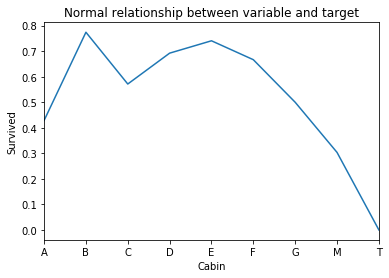

In [19]:
# let's inspect the newly created monotonic relationship with the target

#first we plot the original variable for comparison, there is no monotonic relationship

fig = plt.figure()
fig = X_train.groupby(['Cabin'])['Survived'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('Survived')

Text(0, 0.5, 'Survived')

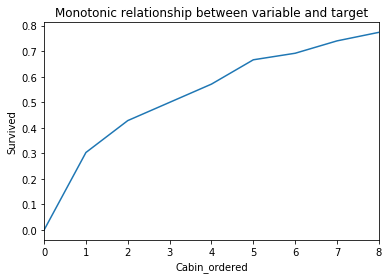

In [20]:
# plot the transformed result: the monotonic variable

fig = plt.figure()
fig = X_train.groupby(['Cabin_ordered'])['Survived'].mean().plot()
fig.set_title('Monotonic relationship between variable and target')
fig.set_ylabel('Survived')

There is now a monotonic relationship between the variable Cabin and probability of survival. The higher the Cabin number, the more likely the person was to survive.

### Note

Monotonic does not mean strictly linear. Monotonic means that it increases constantly, or it decreases constantly.

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand, as we explained in previous sections.